In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.special import gamma
from scipy.optimize import differential_evolution

from tqdm import tqdm

In [41]:
np.random.seed(42)
plt.style.use('ggplot')

In [5]:
coordinates_df = pd.read_csv('../data/coordinates.csv')
coordinates_df.head(1)

,cluster,station,X,Y,Z
0,1,1.1,-25.359,5.885,-6.684


In [16]:
theta = 30
phi = 10

X0 = 0
Y0 = 0
Z0 = -18

s = 1.2
Ne = 1.1e7

In [17]:
def compute_r(X0, Y0, Z0, theta, phi, coordinates_df):
    theta = np.radians(theta)
    phi = np.radians(phi)

    v = np.array([np.cos(phi) * np.sin(theta), np.sin(phi)
                 * np.sin(theta), np.cos(theta)])

    P0 = np.array([X0, Y0, Z0])

    P = np.vstack(
        (coordinates_df['X'], coordinates_df['Y'], coordinates_df['Z'])).T

    cross_product = np.cross(P - P0, v)

    r = np.linalg.norm(cross_product, axis=1) / np.linalg.norm(v)

    return r

In [19]:
def rho_model(r, Ne, s, r_m=78):
    term1 = Ne / (2 * np.pi * r_m**2)
    term2 = (r / r_m) ** (s - 2)
    term3 = (1 + r / r_m) ** (s - 4.5)
    term4 = gamma(4.5 - s) / (gamma(s) * gamma(4.5 - 2 * s))
    return term1 * term2 * term3 * term4

In [21]:
def loss_function(params, coordinates_df, rho, theta, phi, Z0):
    X0, Y0, Ne, s = params
    r = compute_r(X0, Y0, Z0, theta, phi, coordinates_df)
    rho_calc = rho_model(r, Ne, s)
    return np.mean((rho_calc - rho) ** 2)

In [18]:
r = compute_r(X0, Y0, Z0, theta, phi, coordinates_df)

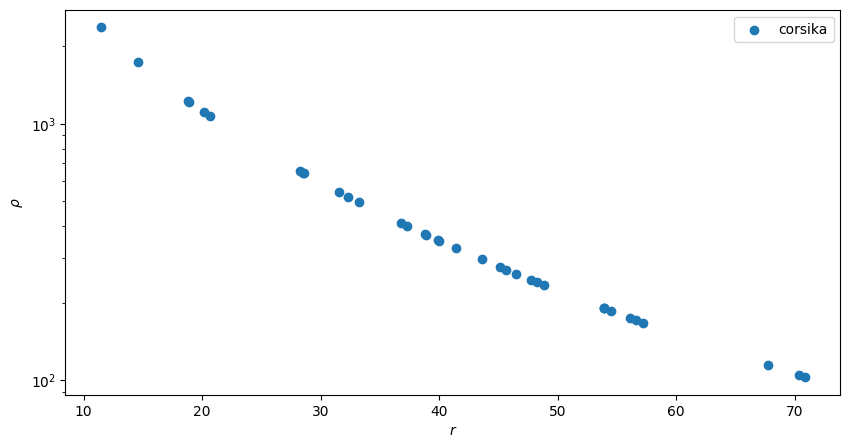

In [ ]:
rho = rho_model(r, Ne, s)

plt.figure(figsize=(10, 5))
plt.scatter(r, rho, label="ФПР")
plt.xscale("linear")
plt.yscale("log")
plt.xlabel(r"$r$")
plt.ylabel(r"$\rho$")
plt.legend()
plt.show()

In [ ]:
initial_params = [10, 10, 1e4, 1.5]  # X0, Y0, Ne, s
bounds = [
    (-100, 100),
    (-100, 100),
    (0, 1e9),
    (0, 3)
]

In [24]:
result = differential_evolution(loss_function, bounds, args=(
    coordinates_df, rho, theta, phi, Z0))

In [25]:
X0_opt, Y0_opt, Ne_opt, s_opt = result.x
print(
    f"Оптимальные параметры: X0={X0_opt}, Y0={Y0_opt}, Ne={Ne_opt}, s={s_opt}")

Оптимальные параметры: X0=0.0, Y0=0.0, Ne=11000000.0, s=1.2


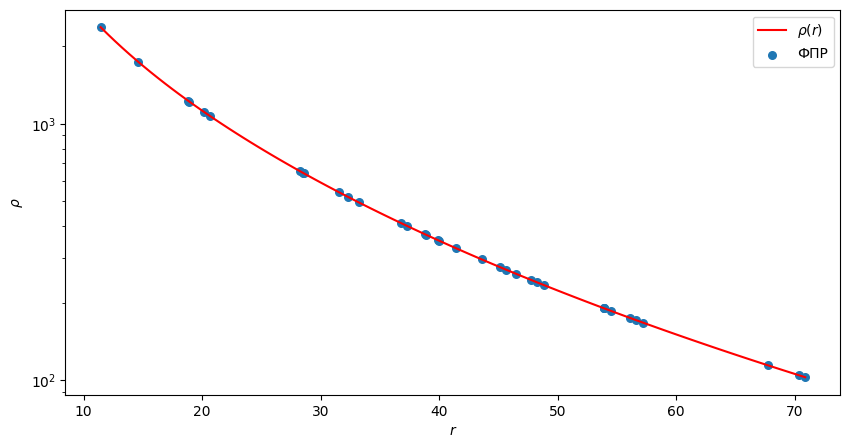

In [38]:
r_values = np.linspace(min(r), max(r), 100)
rho_values = rho_model(r_values, Ne, s)

r_opt = compute_r(X0_opt, Y0_opt, Z0, theta, phi, coordinates_df)
rho_fit = rho_model(r_opt, Ne_opt, s_opt)

plt.figure(figsize=(10, 5))
plt.plot(r_values, rho_values, label=r'$\rho(r)$', color="red")
plt.scatter(r_opt, rho_fit, label="ФПР", s=30)
plt.xscale("linear")
plt.yscale("log")
plt.xlabel(r"$r$")
plt.ylabel(r"$\rho$")
plt.legend()
plt.show()

Отгенеририм много событий

In [66]:
Z0 = -18
num_events = 1000

theta = np.round(np.random.uniform(0, 70, num_events), 1)
phi = np.round(np.random.uniform(190, 350, num_events), 1)
X0 = np.round(np.random.uniform(-40, 40, num_events), 1)
Y0 = np.round(np.random.uniform(-40, 40, num_events), 1)
Ne = np.round(np.random.uniform(0, 1e9, num_events), -6)
s = np.round(np.random.uniform(0, 3, num_events), 1)

In [67]:
data = pd.DataFrame({
    "theta": theta,
    "phi": phi,
    "X0": X0,
    "Y0": Y0,
    "Z0": Z0,
    "Ne": Ne,
    "s": s
})

data.head(3)

,theta,phi,X0,Y0,Z0,Ne,s
0,35.5,342.3,-25.3,5.3,-18,841000000.0,2.4
1,65.4,243.1,-32.3,-21.0,-18,749000000.0,1.5
2,2.0,244.7,-17.8,26.5,-18,244000000.0,0.8


In [ ]:
r_values = []
rho_values = []
result_values = []

X0_opt_values = []
Y0_opt_values = []
Ne_opt_values = []
s_opt_values = []


for index, event in tqdm(data.iterrows(), total=len(data), desc='~'):
    r_values.append(compute_r
                    (
                        event['X0'],
                        event['Y0'],
                        event['Z0'],
                        event['theta'],
                        event['phi'],
                        coordinates_df
                    ))

    rho_values.append(rho_model
                      (
                          r_values[index],
                          event['Ne'],
                          event['s']
                      )
                      )

    result_values.append(differential_evolution
                         (
                             loss_function,
                             bounds,
                             args=(coordinates_df, rho_values[index], event['theta'], event['phi'], event['Z0']
                                   )
                         ))

    X0_opt, Y0_opt, Ne_opt, s_opt = result_values[index].x
    X0_opt_values.append(X0_opt)
    Y0_opt_values.append(Y0_opt)
    Ne_opt_values.append(Ne_opt)
    s_opt_values.append(s_opt)

~:  75%|███████▌  | 754/1000 [1:05:47<27:33,  6.72s/it]

In [ ]:
X0_opt = np.array(X0_opt_values)
Y0_opt = np.array(Y0_opt_values)
Ne_opt = np.array(Ne_opt_values)
s_opt = np.array(s_opt_values)

In [ ]:
X0_diff = X0 - X0_opt
Y0_diff = Y0 - Y0_opt
Ne_diff = Ne - Ne_opt
s_diff = s - s_opt

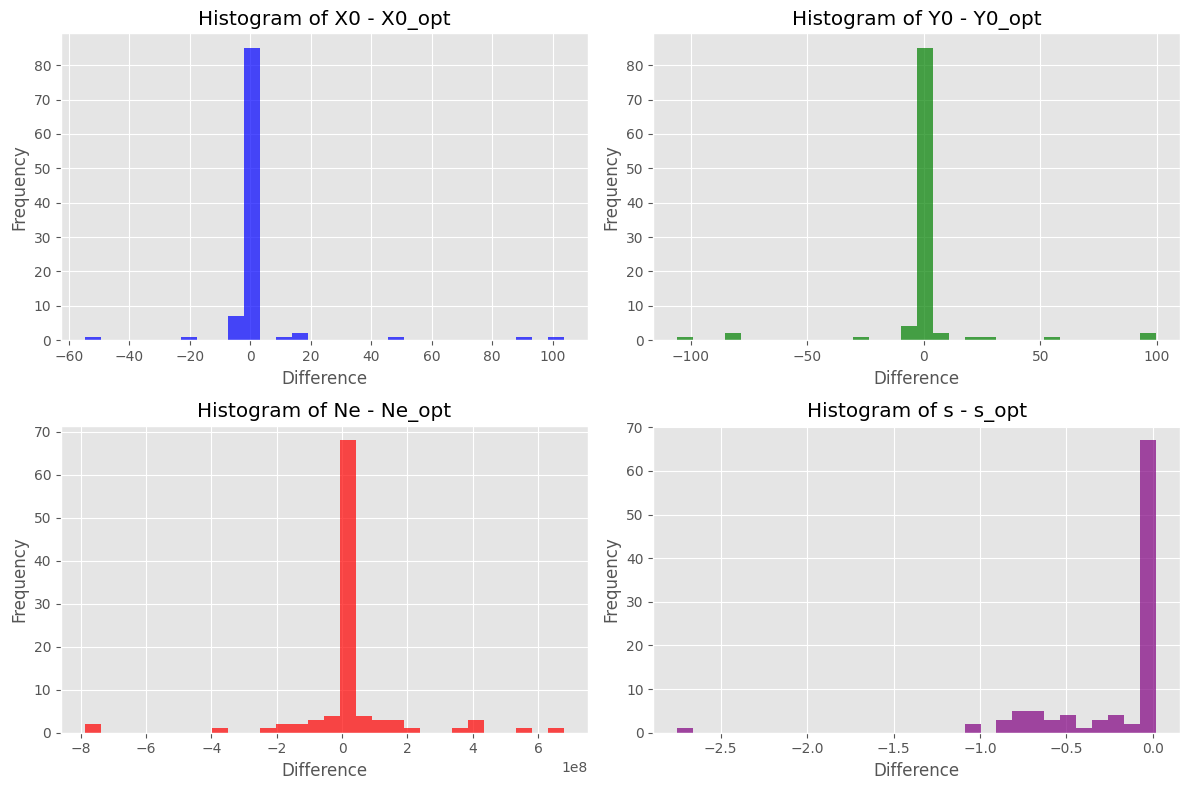

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(X0_diff, bins=30, color='blue', alpha=0.7)
plt.title('X0 - X0_opt')
plt.xlabel('Difference')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(Y0_diff, bins=30, color='green', alpha=0.7)
plt.title('Y0 - Y0_opt')
plt.xlabel('Difference')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(Ne_diff, bins=30, color='red', alpha=0.7)
plt.title(' Ne - Ne_opt')
plt.xlabel('Difference')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(s_diff, bins=30, color='purple', alpha=0.7)
plt.title('s - s_opt')
plt.xlabel('Difference')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()